In [1]:
#!/usr/bin/env python
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
import pandas as pd
from scipy.stats import pearsonr,spearmanr

import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1)) #allow many plots

rez=600

#import parameters
PK=pd.DataFrame.from_csv('data/PK10.csv')
PD=pd.DataFrame.from_csv('data/PDB.csv')
vd=pd.DataFrame.from_csv('data/viral_dynamics.csv')


In [2]:
#whole Ab model
def Ab_model(t,ab_ps):
    Y1,Y2,k1,k2,h,IC50=ab_ps
    Y_t = Y1*np.exp(-k1*t)+Y2*np.exp(-k2*t)
    I_t = 1/(1+(Y_t/IC50)**-h)*100
    return Y_t,I_t


In [3]:
#the functions to model the same process stochastically with the hybrid stochastic model

#updating the rates of events
num_rates=21; num_states=7; rl=np.zeros(num_rates); T=np.zeros([num_states,num_rates])

def update_rates(X,ti,v_ps,ab_ps):
        
    S,AU,AP,LU,LP,E,V=X; #easier to read if variables actually spelled out

    aS,dS,Bt0,tau,lam,dA,thL,xi,k,aE,dE,E50,w,p,g=v_ps #viral dynamics parameters
    Y1,Y2,k1,k2,h,IC50=ab_ps #bnab parameters

    tAb=ti%56
    Bt=Bt0*(1-1/(1+((Y1*np.exp(-k1*tAb)+Y2*np.exp(-k2*tAb))/IC50)**-h)) #compute Ab effect on infectivity
                
    pr=np.random.poisson(p)    #kp=0.1; pr=np.random.gamma(kp,p)

    rl[0] = aS;                     T[:,0] =[1,0,0,0,0,0,0];  #constant production 
    rl[1] = dS*S;                   T[:,1] =[-1,0,0,0,0,0,0]  #density dependent susceptible death
    rl[2] = (1-tau)*(1-lam)*Bt*S*V; T[:,2] =[-1,1,0,0,0,0,-1] #unproductive active infection
    rl[3] = tau*(1-lam)*Bt*S*V;     T[:,3] =[-1,0,1,0,0,0,-1] #productive active infection
    rl[4] = (1-tau)*lam*Bt*S*V;     T[:,4] =[-1,0,0,1,0,0,-1] #unproductive latent infection
    rl[5] = tau*lam*Bt*S*V;         T[:,5] =[-1,0,0,0,1,0,-1] #productive latent infection
    rl[6] = dA*AU;                  T[:,6] =[0,-1,0,0,0,0,0]  #unproductive active death
    rl[7] = dA*AP;                  T[:,7] =[0,0,-1,0,0,0,pr]  #productive active death and virus burst
    rl[8] = dL*LU;                  T[:,8] =[0,0,0,-1,0,0,0]  #unproductive latent death
    rl[9] = dL*LP;                  T[:,9] =[0,0,0,0,-1,0,0]  #productive latent death
    rl[10] = aL*LU;                 T[:,10]=[0,0,0,1,0,0,0]  #unproductive latent proliferation
    rl[11] = aL*LP;                 T[:,11]=[0,0,0,0,1,0,0]  #productive latent proliferation
    rl[12] = xi*LU;                 T[:,12]=[0,1,0,-1,0,0,0]  #unproductive latent activation
    rl[13] = xi*LP;                 T[:,13]=[0,0,1,0,-1,0,0]  #productive latent activation
    rl[14] = k*E*AU;                T[:,14]=[0,-1,0,0,0,0,0]  #unproductive active immune removal
    rl[15] = k*E*AP;                T[:,15]=[0,0,-1,0,0,0,0]  #productive active immune removal
    rl[16] = w*E*(AP+AU)/(E+E50);   T[:,16]=[0,0,0,0,0,1,0]  #immune cell recruitment
    rl[17] = aE;                    T[:,17]=[0,0,0,0,0,1,0]  #immune cell birth
    rl[18] = dE*E;                  T[:,18]=[0,0,0,0,0,-1,0]  #immune cell clearance
    rl[19] = g*V;                   T[:,19]=[0,0,0,0,0,0,-1]  #innate viral clearance
    
    return rl,T


In [4]:
#function that solves stochastically using tau-leap method
def tauleap_simulate(X0,t,inc_time,v_ps,ab_ps):

    dt=t[1]; x=X0; y=[] #initialize
    inf_flag=0 #flag to add the infected cell at inc_time
    
    for ti in t:
        
        y.append(x) #the list of states
        
        rl,T = update_rates(x,ti,v_ps,ab_ps) #make new rate vector
        
        events = np.random.poisson(rl*dt) #calculate events
        
        dx = np.sum(T*events,1) #calculate change in state
        
        x=x+dx #update state variable
        
        x[x<0]=0 #make sure no negative numbers
        
        #add a single infected cell
        if ti>=inc_time and inf_flag==0:
            x[2] = x[2] + 1 #add 1 active productively infected cell at the contact time
            inf_flag=1
               
    return np.array(y)

3.803967391304348


/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in double_scalars
/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in reciprocal


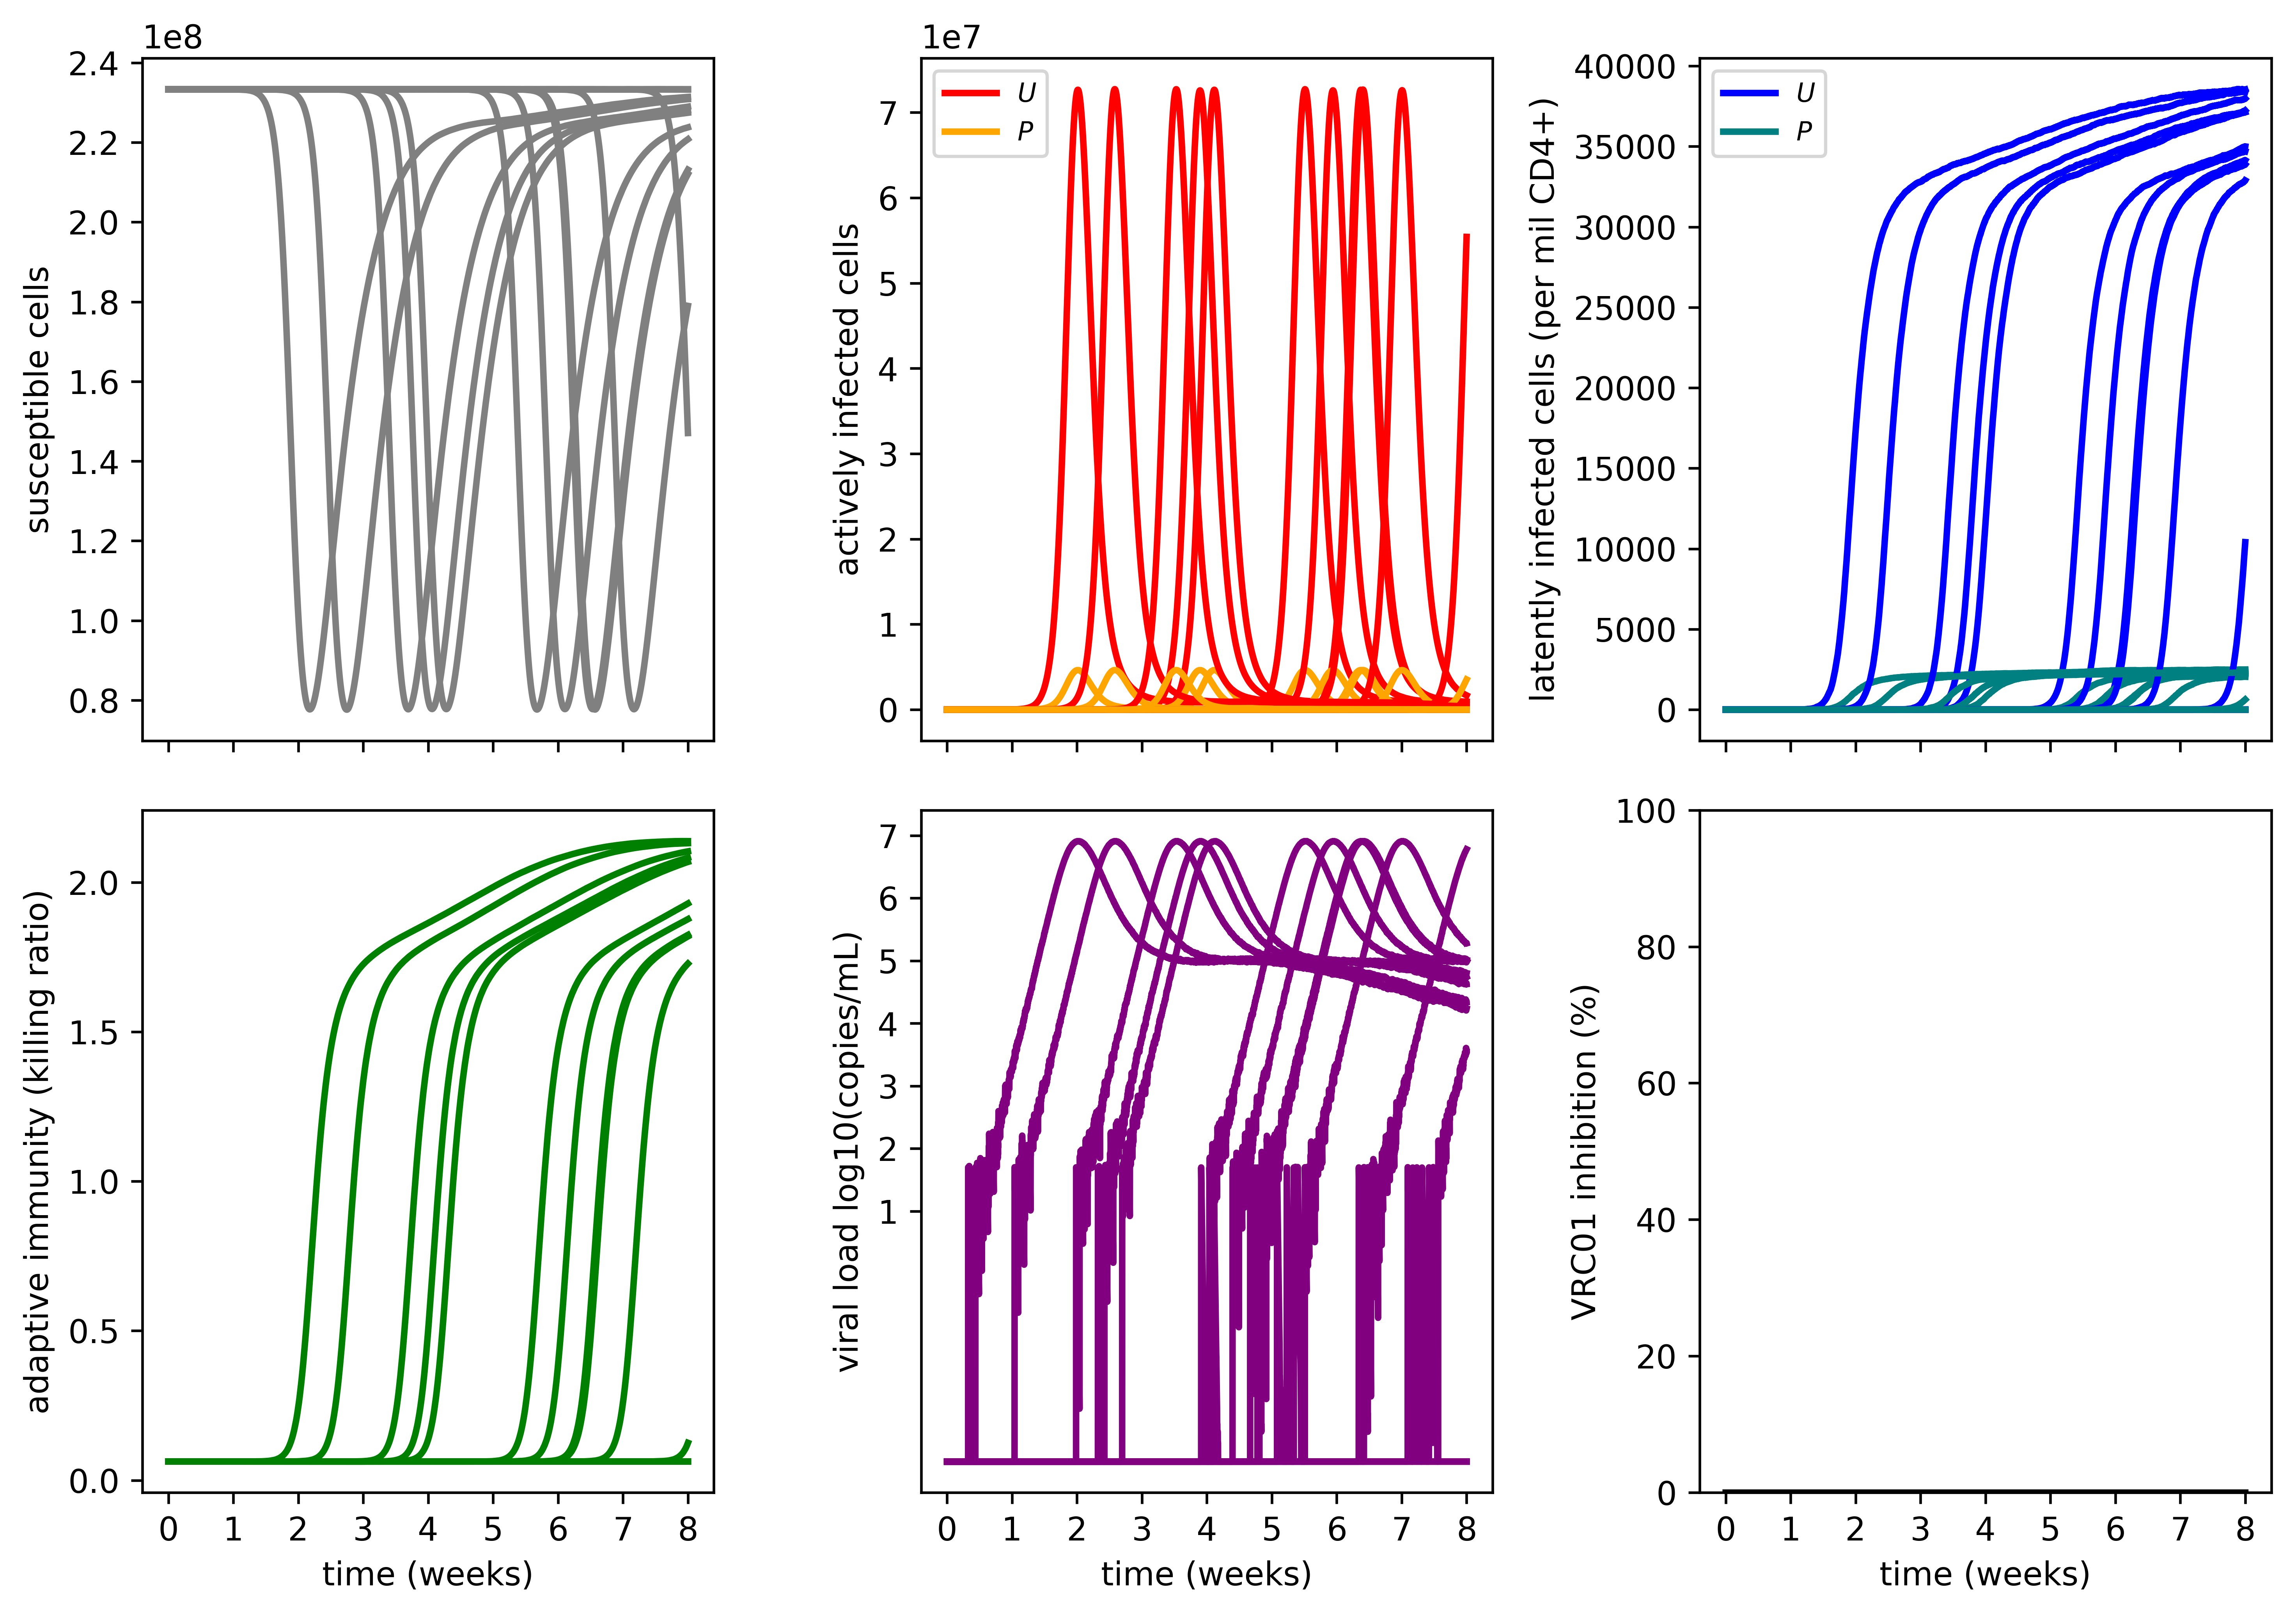

In [7]:
#do some simple simulations with fixed parameters

# parameters for viral dynamics model
vol = 1e6      # volume of blood [uL]
aS  = 70*vol;   #constant growth rate of susceptibles [cells/uL/day]
dS  = 0.3;   #susceptible death rate [1/day] 
Bt0 = 1e-4/vol  # infection rate of T-cells [uL/cells-day]/[uL]
dA  = 0.8       # active death rate [1/day]
p   = 5e4       # burst rate of virus from cells [virions/cell]
g   = 23        # virus clearance rate [1/day]
tau = 0.06      # productive infection probability []
lam = 1e-4      # latency probability []
thL = 5.2e-4    # latent clearance rate [1/day]
aL  = 0.015;    # latent proliferation rate [1/day] (Tcm)
xi  = 1e-5;     # latent activation rate [1/day]
dL  = aL-thL-xi # latent death rate
k   = 1/vol;  #immune cell killing rate [uL/cell-day]/[uL]
w   = 2.9;     #immune cell multiplier [1/day]
aE  = 1e-4*vol;   #initial E cell concentration [cells/uL]*[uL]
dE  = 0.002;  #immune death rate [1/day]
E50 = 250*vol;   #50 pct max E cell concentration [cells/uL]*[uL]

R0=aS*Bt0*tau*(1-lam)*p/g/dS/dA; print(R0) # basic reproductive number

Y1=0
Y2=0
k1=1
k2=0.1
h=1
IC50=10

t=np.linspace(0,56,1e4) #time for antibody dose

X0=np.round([aS/dS,0,0,0,0,aE/dE,0]) #always true because virus gets added at inc_time

v_ps = aS,dS,Bt0,tau,lam,dA,thL,xi,k,aE,dE,E50,w,p,g #viral dynamics parameters
ab_ps = Y1,Y2,k1,k2,h,IC50 #bnab parameters

num_sims=15

plt.figure(figsize=(10,7),dpi=rez)
for i in range(num_sims):
    
    t0=np.random.rand()*56 #time of crossing mucosal barrier
    sol=tauleap_simulate(X0,t,t0,v_ps,ab_ps)

    plt.subplot(231)
    plt.plot(t/7,sol[:,0],'gray',lw=2)
    plt.ylabel('susceptible cells')

    plt.subplot(232)
    plt.plot(t/7,sol[:,1],'red',lw=2)
    plt.plot(t/7,sol[:,2],'orange',lw=2)
    plt.ylabel('actively infected cells')
    plt.legend(['$U$','$P$'],fontsize=8)

    plt.subplot(233)
    plt.plot(t/7,sol[:,3],'blue',lw=2) #divide by 1000 CD4+ T cells and then multiply by 1 million
    plt.plot(t/7,sol[:,4],'teal',lw=2)
    plt.ylabel('latently infected cells (per mil CD4+)')
    plt.legend(['$U$','$P$'],fontsize=8)

    plt.subplot(234)
    plt.plot(t/7,sol[:,5]*k/dA,color='green',lw=2)
    plt.ylabel('adaptive immunity (killing ratio)')

    plt.subplot(235)
    vll=np.log10(sol[:,6]/vol*1e3+1e-3)
    plt.plot(t/7,vll,'purple',lw=2)
    plt.ylabel('viral load log10(copies/mL)')
    plt.yticks(range(1,8,1))

    for i in range(6):
        plt.subplot(231+i)
        if i>2:
            plt.xlabel('time (weeks)')
            plt.xticks(range(0,9,1))
        else:
            plt.xticks(range(0,9,1),[])
    
Y_t,I_t=Ab_model(t,ab_ps)

plt.subplot(236)
plt.plot(t/7,I_t,'black',lw=2)
plt.ylabel('VRC01 inhibition (%)')
plt.ylim([0,100])

plt.tight_layout()


7.06694660183


/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:59: RuntimeWarning: invalid value encountered in true_divide


3.36114759221
9.47783731081
3.71733096937
4.31261918811


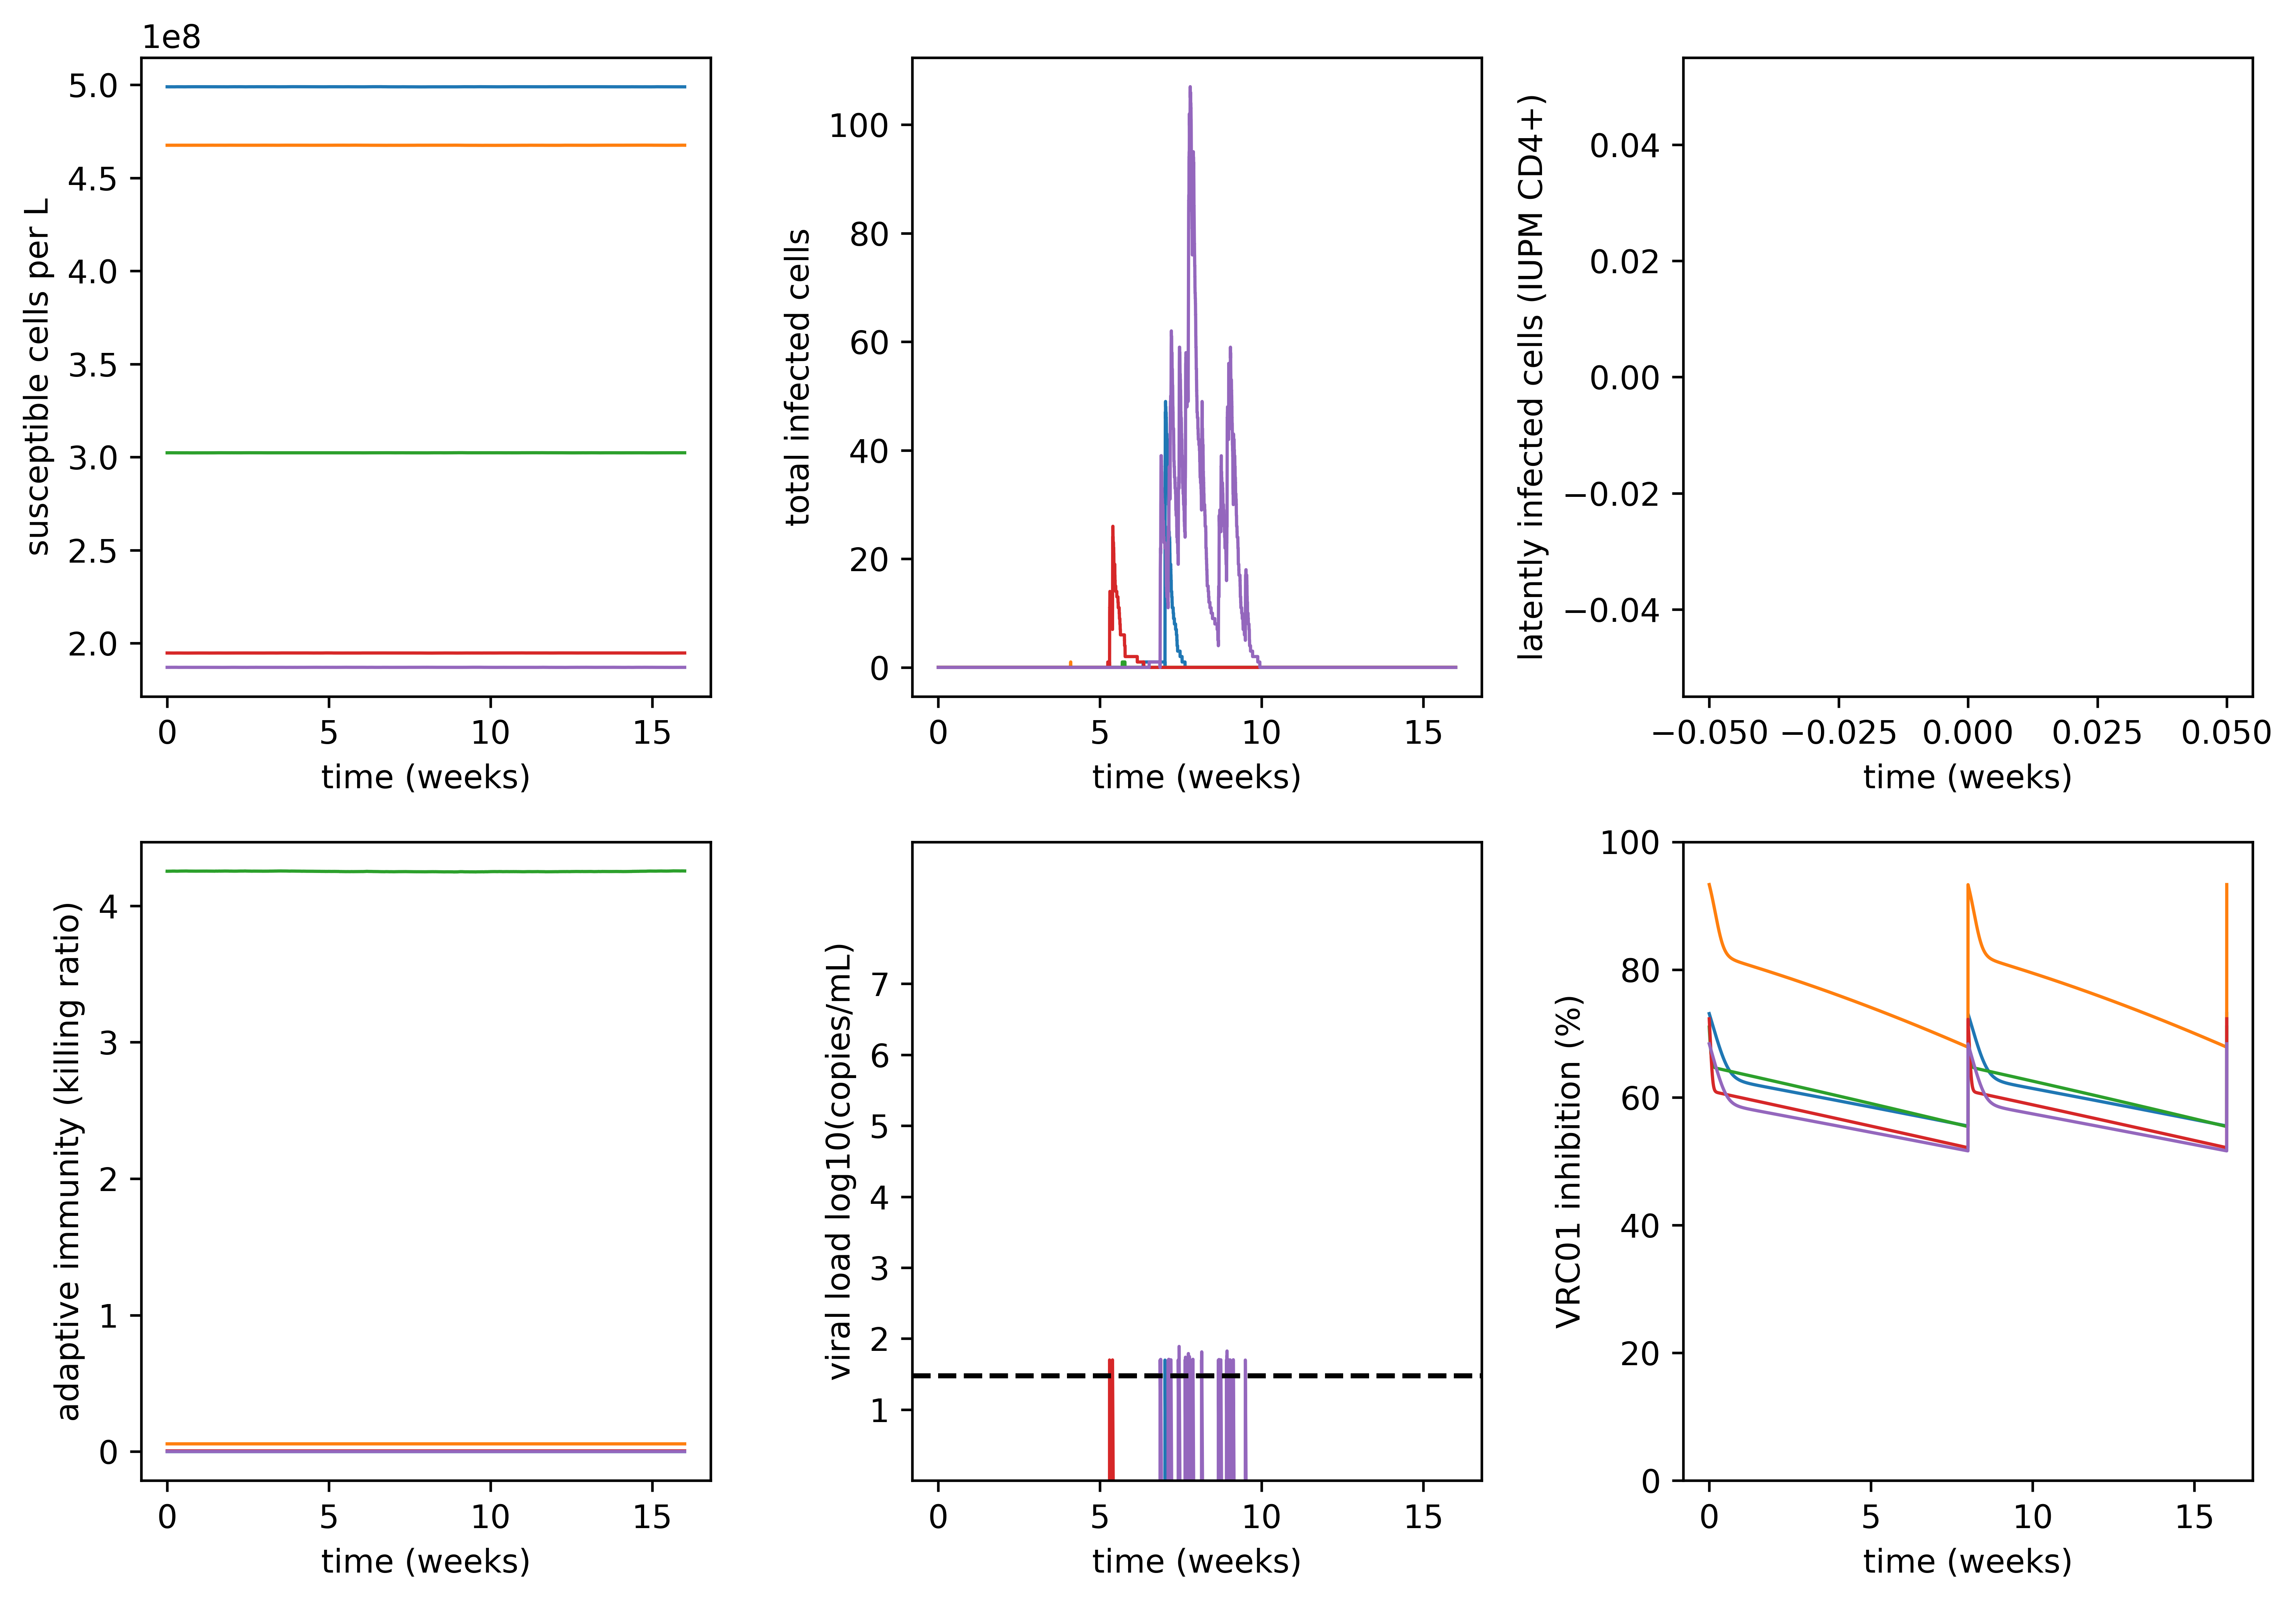

In [6]:
#draw random samples
t=np.linspace(0,7*16,1e4) #time for antibody dose

X0=np.round([aS/dS,0,0,0,0,aE/dE,0]) #always true because virus gets added at inc_time

vol = 1e6      # volume of blood [uL]
aS  = 70*vol;   #constant growth rate of susceptibles [cells/uL/day]
dS  = 0.3;   #susceptible death rate [1/day] 
Bt0 = 1e-4/vol  # infection rate of T-cells [uL/cells-day]/[uL]
dA  = 1       # active death rate [1/day]
p   = 5e4       # burst rate of virus from cells [virions/cell]
g   = 23        # virus clearance rate [1/day]
tau = 0.06      # productive infection probability []
lam = 1e-4      # latency probability []
thL = 5.2e-4    # latent clearance rate [1/day]
aL  = 0.015;    # latent proliferation rate [1/day] (Tcm)
xi  = 1e-5;     # latent activation rate [1/day]
dL  = aL-thL-xi # latent death rate
k   = 1/vol;  #immune cell killing rate [uL/cell-day]/[uL]
w   = 2.9;     #immune cell multiplier [1/day]
aE  = 1e-4*vol;   #initial E cell concentration [cells/uL]*[uL]
dE  = 0.002;  #immune death rate [1/day]
E50 = 250*vol;   #50 pct max E cell concentration [cells/uL]*[uL]

num_sims=5

plt.figure(figsize=(10,7),dpi=rez)
for i in range(num_sims):
        
    Y1,k1,Y2,k2=np.array(PK.iloc[i,:])
    h,IC50=np.array(PD.iloc[i,:])
    ab_ps = Y1,Y2,k1,k2,h,IC50 #bnab parameters
    
    R0,dS,tau,k,dE,E50,w=np.array(vd.iloc[i,:])
    k=k/vol
    E50=E50*vol
    print(R0)
    v_ps = aS,dS,Bt0,tau,lam,dA,thL,xi,k,aE,dE,E50,w,p,g #viral dynamics parameters VOLUME ADJUSTED

    t0=np.random.rand()*56 #time of crossing mucosal barrier
    X0=np.round([aS/dS,0,0,0,0,aE/dE,0]) #always true because virus gets added at inc_time
    sol=tauleap_simulate(X0,t,t0,v_ps,ab_ps)

    plt.subplot(231)
    plt.plot(t/7,sol[:,0],lw=1)#,c=plt.cm.cool(i))
    plt.ylabel('susceptible cells per L')
    plt.xlabel('time (weeks)')
    #plt.xticks(range(0,9,1))
    #plt.axvline(4,color='gray',lw=2)
    #plt.axvline(8,color='black',lw=2)

    plt.subplot(232)
    plt.plot(t/7,sol[:,1]+sol[:,2],lw=1)
    plt.ylabel('total infected cells')
    plt.xlabel('time (weeks)')
    #plt.xticks(range(0,9,1))

    plt.subplot(233)
    plt.plot(t/7,sol[:,3]/sol[0,1]*1e6,lw=1) #divide by 1000 CD4+ T cells and then multiply by 1 million
    #plt.plot(t/7,sol[:,4]/sol[0,1]*1e6,'teal',lw=2)
    plt.ylabel('latently infected cells (IUPM CD4+)')
    #plt.legend(['$U$','$P$'],fontsize=8)
    plt.xlabel('time (weeks)')
    #plt.xticks(range(0,9,1))

    plt.subplot(234)
    plt.plot(t/7,sol[:,5]*k/dA,lw=1)
    plt.ylabel('adaptive immunity (killing ratio)')
    plt.xlabel('time (weeks)')
    #plt.xticks(range(0,9,1))

    plt.subplot(235)
    vll=np.log10(sol[:,6]/vol*1e3+1e-3)
    plt.plot(t/7,vll,lw=1)
    plt.axhline(np.log10(30),color='k',ls='--')
    plt.ylabel('viral load log10(copies/mL)')
    plt.yticks(range(1,9,1))
    plt.xlabel('time (weeks)')
    #plt.xticks(range(0,9,1))
    plt.ylim([0,9])

    Y_t,I_t=Ab_model(t%56,ab_ps)

    plt.subplot(236)
    plt.plot(t/7,I_t,lw=1)
    plt.ylabel('VRC01 inhibition (%)')
    plt.ylim([0,100])
    plt.xlabel('time (weeks)')
    #plt.xticks(range(0,9,1))
    

plt.tight_layout()


In [ ]:
#draw random samples
t=np.linspace(0,7*16,1e4) #time for antibody dose

X0=np.round([aS/dS,0,0,0,0,aE/dE,0]) #always true because virus gets added at inc_time

vol = 1e6      # volume of blood [uL]
aS  = 70*vol;   #constant growth rate of susceptibles [cells/uL/day]
dS  = 0.3;   #susceptible death rate [1/day] 
Bt0 = 1e-4/vol  # infection rate of T-cells [uL/cells-day]/[uL]
dA  = 0.8       # active death rate [1/day]
p   = 5e4       # burst rate of virus from cells [virions/cell]
g   = 23        # virus clearance rate [1/day]
tau = 0.06      # productive infection probability []
lam = 1e-4      # latency probability []
thL = 5.2e-4    # latent clearance rate [1/day]
aL  = 0.015;    # latent proliferation rate [1/day] (Tcm)
xi  = 1e-5;     # latent activation rate [1/day]
dL  = aL-thL-xi # latent death rate
k   = 1/vol;  #immune cell killing rate [uL/cell-day]/[uL]
w   = 2.9;     #immune cell multiplier [1/day]
aE  = 1e-4*vol;   #initial E cell concentration [cells/uL]*[uL]
dE  = 0.002;  #immune death rate [1/day]
E50 = 250*vol;   #50 pct max E cell concentration [cells/uL]*[uL]

num_sims=5

plt.figure(figsize=(10,7),dpi=rez)
for i in range(num_sims):
        
    Y1,k1,Y2,k2=np.array(PK.iloc[i,:])
    h,IC50=np.array(PD.iloc[i,:])
    ab_ps = Y1,Y2,k1,k2,h,IC50 #bnab parameters
    
    R0,dS,tau,k,dE,E50,w=np.array(vd.iloc[i,:])
    k=k/vol
    E50=E50*vol
    print(R0)
    v_ps = aS,dS,Bt0,tau,lam,dA,thL,xi,k,aE,dE,E50,w,p,g #viral dynamics parameters VOLUME ADJUSTED

    t0=np.random.rand()*56 #time of crossing mucosal barrier
    X0=np.round([aS/dS,0,0,0,0,aE/dE,0]) #always true because virus gets added at inc_time
    sol=tauleap_simulate(X0,t,t0,v_ps,ab_ps)

    plt.subplot(231)
    plt.plot(t/7,sol[:,0],lw=1)#,c=plt.cm.cool(i))
    plt.ylabel('susceptible cells per L')
    plt.xlabel('time (weeks)')
    #plt.xticks(range(0,9,1))
    #plt.axvline(4,color='gray',lw=2)
    #plt.axvline(8,color='black',lw=2)

    plt.subplot(232)
    plt.plot(t/7,sol[:,1]+sol[:,2],lw=1)
    plt.ylabel('total infected cells')
    plt.xlabel('time (weeks)')
    #plt.xticks(range(0,9,1))

    plt.subplot(233)
    plt.plot(t/7,sol[:,3]/sol[0,1]*1e6,lw=1) #divide by 1000 CD4+ T cells and then multiply by 1 million
    #plt.plot(t/7,sol[:,4]/sol[0,1]*1e6,'teal',lw=2)
    plt.ylabel('latently infected cells (IUPM CD4+)')
    #plt.legend(['$U$','$P$'],fontsize=8)
    plt.xlabel('time (weeks)')
    #plt.xticks(range(0,9,1))

    plt.subplot(234)
    plt.plot(t/7,sol[:,5]*k/dA,lw=1)
    plt.ylabel('adaptive immunity (killing ratio)')
    plt.xlabel('time (weeks)')
    #plt.xticks(range(0,9,1))

    plt.subplot(235)
    vll=np.log10(sol[:,6]/vol*1e3+1e-3)
    plt.plot(t/7,vll,lw=1)
    plt.axhline(np.log10(30),color='k',ls='--')
    plt.ylabel('viral load log10(copies/mL)')
    plt.yticks(range(1,9,1))
    plt.xlabel('time (weeks)')
    #plt.xticks(range(0,9,1))
    plt.ylim([0,9])

    Y_t,I_t=Ab_model(t%56,ab_ps)

    plt.subplot(236)
    plt.plot(t/7,I_t,lw=1)
    plt.ylabel('VRC01 inhibition (%)')
    plt.ylim([0,100])
    plt.xlabel('time (weeks)')
    #plt.xticks(range(0,9,1))
    

plt.tight_layout()


In [ ]:

################################################################################
#local sensitivity analysis function

#variables to check sensitivity
variables = ['first positive time ' + r'$t_{+}$',
             'initial bnAb conc ' + r'$A_0$', 
             '2nd phase bnAb ratio ' + r'$\phi$',
             'decay rate 1 ' + r'$r$',
             'decay rate 2 ' + r'$s$',
             'Hill coefficient ' + r'$h$',
             '50% effectiveness ' + r'$IC_{50}$',
            'stochastic variation']#,'bnAb efficacy ' + r'$\psi$']

#from data_analysis fitting:
#[86  2.5 0.15 0.007] +/- [ 32.7 32.6 0.12 0.29 ]
#[240 2.9 0.086 -0.011] +/- [ 112 116 0.081 0.71]

#ranges of variables for LHS, mostly made up to consider all options
rangez= np.array([
            [0,56],   #t+
            [0,600],  #A0
            [0,20],  #phi
            [0,0.3],  #r
            [0,0.7],  #s
            [1,5],    #h
            [0.2,20], #IC50
            [0,10]])  #psi 
                            
t=np.linspace(0,56,1e3) #8 week time series in days

fig,axarr = plt.subplots(2,4,sharex=True,sharey=True,figsize=(9,4),dpi=rez)
#looping over the number of variables to check sensitivity
for i in range(len(variables)):

    #set values at initials, mean??
    lo=np.mean(rangez,1); hi=np.mean(rangez,1);      

    lo[0]=7; hi[0]=7; #make sure first pos is at 1 week
    
    #change the i-th parameter
    lo[i]=rangez[i][0]; hi[i]=rangez[i][1]
    
    #evaluate model
    fp_time,A0,phi,r,s,hill,IC50,psi=lo
    lo_sol = bnabs_tauleap(t,fp_time,A0,phi,r,s,hill,IC50,psi)
    
    fp_time,A0,phi,r,s,hill,IC50,psi=hi
    hi_sol = bnabs_tauleap(t,fp_time,A0,phi,r,s,hill,IC50,psi)

    ax=axarr[i%2][int(i/2.)]
    ax.fill_between(t/7,lo_sol[:,6]/vol*1e3,hi_sol[:,6]/vol*1e3,alpha=0.6)
    #ax.semilogy(t/365,med[5],t,HI_sol[5],alpha=0.1,color='chocolate')
    #ax.fill_between(t/365,LO_sol[5],HI_sol[5],alpha=0.5,color='tomato') #observed
    #ax.fill_between(t/365,LO_sol[6],HI_sol[6],alpha=0.5,color='limegreen') #de novo

    #ax.set_ylim([0.1,100])
    ax.set_title(variables[i],fontsize=10)# + str(rangez[i][0]) + r'$\to$' +str(rangez[i][1]),fontsize=10)
    ax.set_xticks(np.linspace(0,8,9))

axarr[0][0].set_ylabel('VL (copies/mL)',fontsize=10)
axarr[1][0].set_ylabel('VL (copies/mL)',fontsize=10)
axarr[0][0].set_ylim([1,2e8])
axarr[0][0].set_yscale('log')

for i in range(4):
    axarr[1][i].set_xlabel('time (weeks)')

axarr[0][0].set_yticks(np.logspace(1,8,8))

plt.tight_layout()
plt.savefig('figures/sensitivity_local.pdf')




In [ ]:
################################################################################
#global sensitivity analysis function

sampz=500

lhs_samples = pyDOE.lhs( int(len(variables)), samples=sampz, criterion='center')

t=np.linspace(0,56,1e3) #8 week time series in days

var_vals=np.zeros(len(variables))
var_vals_list=np.zeros([len(variables),sampz])

peak_list=np.zeros(sampz)
tpeak_list=np.zeros(sampz)
sp_list=np.zeros(sampz)
CD8_list=np.zeros(sampz)

if sampz<101:
    fig, ax = plt.subplots(1,2,figsize=(4,3),dpi=rez,sharex=True)

#looping over the number of LHS samples
for i in range(sampz):

    #I3_0    = 10**(np.log10(rangez[0][0]) + lhs_samples[i][0]*(np.log10(rangez[0][1])-np.log10(rangez[0][0])))

    #make the variable values using the LHS sampling
    for j in range(len(variables)):
        var_vals[j]=rangez[j][0] + lhs_samples[i][j]*(rangez[j][1]-rangez[j][0])

    var_vals_list[:,i]=var_vals
    
    fp_time,c1,c2,r1,r2,hill,IC50,psi=var_vals
    sol = bnabs_tauleap(t,fp_time,A0,phi,r,s,hill,IC50,psi) #solve the model for this LHS list

    fp_index=np.argwhere(fp_time<t)[0][0]
    peak=np.max(sol[fp_index:,6]/vol*1e3)
    tpeak=t[np.argwhere(sol[:,6]/vol*1e3==peak)[0][0]]    

    peak_list[i]=peak
    tpeak_list[i]=tpeak
    CD8_list[i]=sol[-1,5]
    
    if (fp_index+250)<len(t):
        sp=np.mean(sol[fp_index+250:,6]/vol*1e3) #2 weeks later
    else:
        sp=0
        
    sp_list[i]=sp

    if sampz<101:
        #make plots showing variation              
        ax[0].semilogy(t/7,sol[:,6]/vol*1e3,alpha=0.3)
        ax[0].set_ylabel('VL (copies/mL)')
        ax[0].set_xlabel('time (weeks)')

        Ab_t,E_t = Ab_model(t%56,c1,c2,r1,r2,hill,IC50)    #refreshes every 8 weeks
        ax[1].plot(t/7, R0*(1-E_t),alpha=0.3)
        ax[1].set_ylabel('$\mathcal{R}(Ab,t)$')
        ax[0].set_xlabel('time (weeks)')
        ax[0].set_xticks(np.linspace(0,8,9))

if sampz<101:
    plt.tight_layout()
    plt.savefig('figures/examples.pdf')

In [ ]:
vars_short = ['first pos ' + r'$t_{+}$',
             'initial bnAb conc ' + r'$A_0$', 
             'phase bnAb ratio ' + r'$\phi$',
             'decay 1 ' + r'$r$',
             'decay 2 ' + r'$s$',
             'Hill coef ' + r'$h$',
             '50% effect ' + r'$IC_{50}$',
             'bnAbs ' + r'$\psi$']

corr_peak=np.zeros([len(variables),2])
corr_tpeak=np.zeros([len(variables),2])
corr_sp=np.zeros([len(variables),2])
corr_CD8=np.zeros([len(variables),2])

fig,axarr = plt.subplots(4,7,figsize=(14,8),dpi=rez)
for i in range(len(variables)-1):

    #compute correlations (ranked via spearman)
    corr_peak[i]=spearmanr(var_vals_list[i,:],peak_list)
    corr_tpeak[i]=spearmanr(var_vals_list[i,:],tpeak_list)
    corr_sp[i]=spearmanr(var_vals_list[i,:],sp_list)
    corr_CD8[i]=spearmanr(var_vals_list[i,:],CD8_list)

    #because of artificial stopping time for sp calculation
    if i==0:
        corr_sp[i]=spearmanr(var_vals_list[i,:-250],sp_list[:-250])
        
    ax=axarr[0][i]
    ax.scatter(var_vals_list[i,:],peak_list,s=10,alpha=0.5,c='teal')
    #ax.set_xticks(ax.get_xticks()[::2])
    ax.set_yscale('log')
    #ax.set_xscale('log')
    ax.set_ylim([1,2e7])
    ax.set_xlim(rangez[i])
    ax.set_yticks(np.logspace(0,7,8))
    #ax.set_xticks(np.linspace(min(var_vals_list[i,:]),max(var_vals_list[i,:]),5))

    ax=axarr[1][i]
    ax.scatter(var_vals_list[i,:],tpeak_list/7,s=10,alpha=0.5,c='tan')
    #ax.set_xticks(ax.get_xticks()[::2])
    ax.set_xlim(rangez[i])
    #ax.set_xscale('log')
    ax.set_yticks(np.linspace(0,8,9))
    #ax.set_xticks(np.linspace(min(var_vals_list[i,:]),max(var_vals_list[i,:]),5))

    ax=axarr[2][i]
    ax.scatter(var_vals_list[i,:],sp_list,s=10,alpha=0.5,c='gray')
    #ax.set_xticks(ax.get_xticks()[::2])
    #ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([1e3,2e7])
    #ax.set_xlabel(vars_short[i],fontsize=10)
    ax.set_xlim(rangez[i])
    ax.set_yticks(np.logspace(3,7,5))
    #ax.set_xticks(np.linspace(min(var_vals_list[i,:]),max(var_vals_list[i,:]),5))

    ax=axarr[3][i]
    ax.scatter(var_vals_list[i,:],CD8_list,s=10,alpha=0.5,c='olive')
    #ax.set_xticks(ax.get_xticks()[::2])
    #ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.set_ylim([1e3,2e7])
    ax.set_xlabel(vars_short[i],fontsize=10)
    ax.set_xlim(rangez[i])
    #ax.set_yticks(np.logspace(3,7,5))
    #ax.set_xticks(np.linspace(min(var_vals_list[i,:]),max(var_vals_list[i,:]),5))

axarr[0][0].set_ylabel('peak VL \n (copies/mL)',fontsize=10)
axarr[1][0].set_ylabel('time to peak \n (weeks)',fontsize=10)
axarr[2][0].set_ylabel('setpoint VL \n (copies/mL)',fontsize=10)
axarr[3][0].set_ylabel('adaptive cells \n (cells/$\mu$L)',fontsize=10)

plt.tight_layout()
plt.savefig('figures/sensitivity_global_scatters.pdf')


In [ ]:

vars_short = ['first pos ' + r'$t_{+}$',
             'initial bnAb conc ' + r'$A_0$', 
             'phase bnAb ratio ' + r'$\phi$',
             'decay 1 ' + r'$r$',
             'decay 2 ' + r'$s$',
             'Hill coef ' + r'$h$',
             '50% effect ' + r'$IC_{50}$',
             '']

#correlation coefficient bar plots
plt.figure(figsize=(4,5),dpi=rez)
bspace=np.arange(0,len(variables)*2,2)

#sort the variable names for y axis labels
#indz=cum_corrs[:,0].argsort()
#sorted_vars=[]
#for kk in range(len(variables)):
#    sorted_vars.append(variables[indz[kk]])

corrs=[corr_peak,corr_tpeak,corr_sp,corr_CD8]
cz=['teal','orchid','coral','olive']

llist=[]
for i in range(4):
    l=plt.barh(bspace+i*0.3,corrs[i][:,0],0.4,color=cz[i])
    llist.append(l)
    plt.legend(llist,['peak','tpeak','setpoint','adaptive'],fontsize=8,loc='upper center', bbox_to_anchor=(0.6, 1.), ncol=2)
    pval_list=(corrs[i][:,1]<0.05) & (corrs[i][:,1]>0)
    for j in range(len(pval_list)):
        if pval_list[j]==True:
            plt.scatter(-1.2,bspace[j]+i*0.3,color=cz[i],marker='o',s=10)
    pval_list=(corrs[i][:,1]<0.01) & (corrs[i][:,1]>0)
    for j in range(len(pval_list)):
        if pval_list[j]==True:
            plt.scatter(-1.4,bspace[j]+i*0.3,color=cz[i],marker='*',s=10)

#plt.xscale('log')

plt.tick_params(axis='y', which='major', labelsize=12)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.xlim([-1.5,1])
plt.xticks(np.linspace(-1,1,5))

plt.xlabel('spearman correlation '+ r'$\rho$',fontsize=10)
#plt.grid('on')
plt.yticks(bspace,vars_short,fontsize=8)
plt.axvline(-1.1,color='k',lw=0.8)
plt.tight_layout()


plt.savefig('figures/sensitivity_correlation_bars.pdf')
    


In [ ]:
tfirst=var_vals_list[0,:]
A0=var_vals_list[1,:]
phi=var_vals_list[2,:]
r=var_vals_list[3,:]
s=var_vals_list[4,:]
h=var_vals_list[5,:]
A50=var_vals_list[6,:]

At=A0*(np.exp(-tfirst*r)+phi*np.exp(-tfirst*s))

ee=1/(1+(A50/At)**(h))

RA=R0*(1-ee)

#compare At and various metrics
plt.figure(figsize=(7,3),dpi=rez)

plt.subplot(131)
plt.scatter(At,peak_list)
#plt.yscale('log')
#plt.xscale('log')
plt.ylabel('peak VL (copies/mL)')
#plt.xlabel('Ab conc at $t_+$ (mg/mL)')

plt.subplot(132)
plt.scatter(At,tpeak_list/7)
#plt.xscale('log')
plt.ylabel('time at peak viral load (weeks)')
plt.xlabel('Ab conc at $t_+$ (mg/mL)')

plt.subplot(133)
plt.scatter(At,sp_list)
plt.tight_layout()
#plt.yscale('log')
#plt.xscale('log')
plt.ylabel('setpoint VL (copies/mL)')
#plt.xlabel('Ab conc at $t_+$ (mg/mL)')

#compare R0 and various metrics
plt.figure(figsize=(7,3),dpi=rez)
plt.subplot(131)
plt.scatter(RA,peak_list)
plt.yscale('log')
plt.ylabel('peak VL (copies/mL)')
#plt.xlabel('basic reproductive number at first positive')

#plt.yscale('log')
plt.subplot(132)
plt.scatter(RA,tpeak_list/7)
plt.xlabel(r'$\mathcal{R}_0$ at $t_+$')
plt.ylabel('time at peak viral load (weeks)')

plt.subplot(133)
plt.scatter(RA,sp_list)
plt.yscale('log')
#plt.xlabel('basic reproductive number at first positive')
plt.ylabel('setpoint VL (copies/mL)')

plt.tight_layout()
#plt.yscale('log')


In [ ]:
plt.scatter(At,tpeak_list/7)
plt.ylabel('time to peak VL (weeks)')
plt.xlabel('Ab concentration at first positive (mg/mL)')

In [ ]:
plt.scatter(RA,peak_list)
plt.ylabel('peak VL (copies/mL)')
plt.yscale('log')
plt.ylim([1,2e10])
plt.xlabel('R0 at first positive')